In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm
from utils import load_jsonl

pd.options.display.float_format = "{:.3f}".format

In [2]:
tournament = "tournaments/rakuda_koukou_v0_tournament"

## The tournament standings

In [3]:
standings = pd.DataFrame(load_jsonl(tournament + "_result.jsonl"))
standings.head()

,model,elo,num_matches,lower,median,upper,error_y_plus,error_y_minus
0,Open Calm 7B,1037.574,199,1018.647,1044.583,1070.379,25.796,25.937
1,Open Calm 7B - Stormy,1024.059,199,1005.241,1030.341,1055.179,24.838,25.099
2,Rinna 3.6B - PPO,1019.319,200,978.378,1002.161,1025.868,23.707,23.783
3,Rinna 3.6B,919.048,202,898.925,922.740,947.164,24.424,23.815


## Dataframe containing all results

In [4]:
results = pd.DataFrame(load_jsonl(tournament + ".jsonl"))
results.head(1)

,bot1,bot2,prematch_elo1,prematch_elo2,question,question_id,response1,response2,referee_comments,score,postmatch_elo1,postmatch_elo2
0,Rinna 3.6B - PPO,Open Calm 7B,1000.000,1000.000,コロナウイルスが日本経済に及ぼした影響と、それに対する政府の対策を評価してください。,20,はい、日本政府は迅速な対応で感染拡大を防止し、経済の安定化に貢献しました。また、国民に対して...,日本はコロナウイルスによる経済への甚大な被害から立ち直るべく懸命な努力をしています。しかし残...,アシスタント1の回答は、正確で詳細な情報を提供していますが、経済政策についてはほとんど触れら...,2,996.900,1003.100


## Evolution across the tournament and bootstrap error estimate

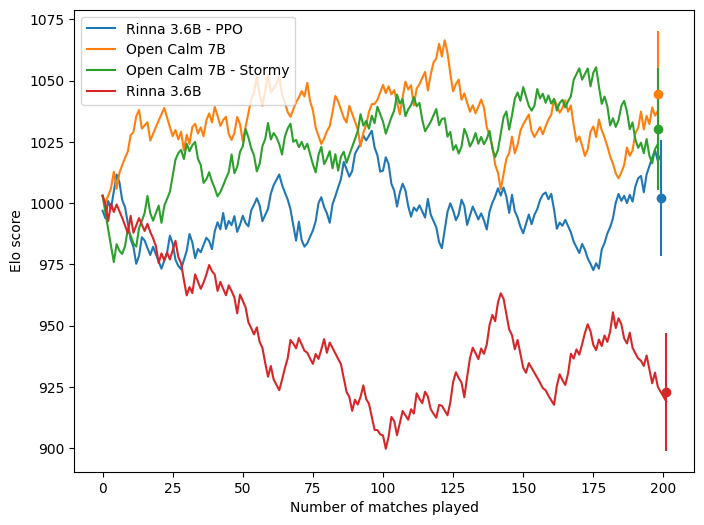

In [5]:
import matplotlib.pyplot as plt

elos = {}
for bot in results.bot1.unique():
    bot_elos = []
    for i, result in results.iterrows():
        if result["bot1"] == bot:
            bot_elos.append(result["postmatch_elo1"])
        elif result["bot2"] == bot:
            bot_elos.append(result["postmatch_elo2"])
        else:
            pass
    elos.update({bot: bot_elos})

fig, ax = plt.subplots(figsize=(8, 6))

standings = standings.set_index("model")
for k, v in elos.items():
    line = ax.plot(v, label=k)
    if k in standings.index:  # check if the model has bootstrap estimates
        # plt.errorbar(len(v) - 1, v[-1],
        #              yerr=[[bootstrap_elo.loc[k, 'error_y_minus']],
        #                    [bootstrap_elo.loc[k, 'error_y']]],
        #              fmt='o',color=line[0].get_color())
        ax.errorbar(
            len(v) - 1,
            standings.loc[k, "median"],
            yerr=[
                [standings.loc[k, "error_y_minus"]],
                [standings.loc[k, "error_y_plus"]],
            ],
            fmt="o",
            color=line[0].get_color()
        )
standings = standings.reset_index()
ax.set_xlabel("Number of matches played")
ax.set_ylabel("Elo score")
plt.legend(loc='upper left')

## Check if the reviewer output distribution is biased

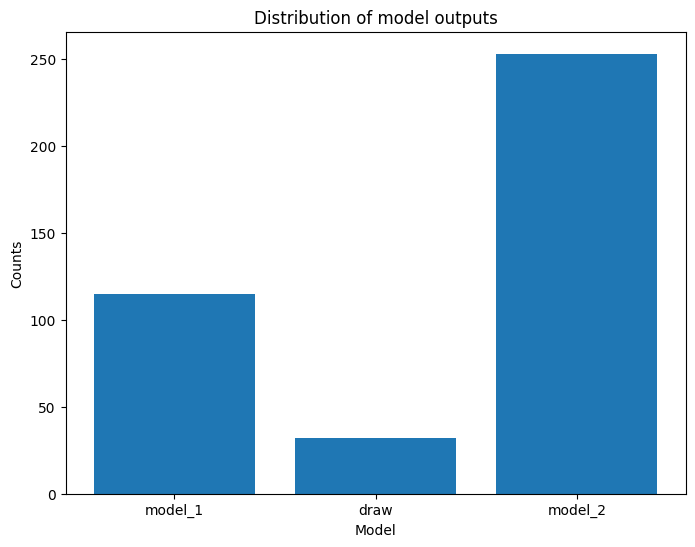

In [6]:
df = results["score"].value_counts()

# Order DataFrame by result
df = df.loc[[1, 3, 2]].reset_index()

# Define labels
labels = ["model_1", "draw", "model_2"]

# Plot
fig, ax = plt.subplots(figsize=(8, 6))
ax.bar(labels, df["count"])
ax.set_xlabel("Model")
ax.set_ylabel("Counts")
ax.set_title("Distribution of model outputs")
plt.show()

## To accelerate convergence with a biased reviewer set the home-field advantage parameter eta

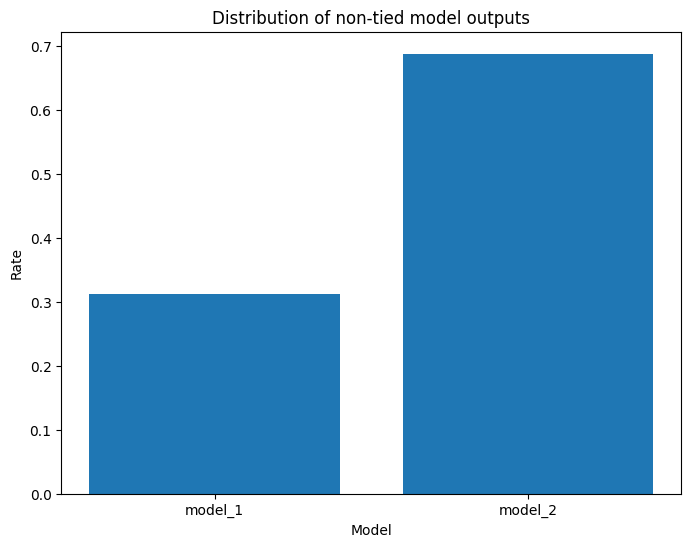

In [7]:
df = results.loc[results["score"]!=3, 'score'].value_counts()
df = df.loc[[1, 2]].reset_index()

# Define labels
labels = ["model_1","model_2"]

# Plot
fig, ax = plt.subplots(figsize=(8, 6))
ax.bar(labels, df["count"]/(df["count"][0]+df["count"][1]))
ax.set_xlabel("Model")
ax.set_ylabel("Rate")
ax.set_title("Distribution of non-tied model outputs")
plt.show()

In [8]:
model1_winrate = df["count"][0]/(df["count"][0]+df["count"][1])
print(model1_winrate)

0.3125


In [9]:
#model1_winrate =  1/(1+BASE**(-IDEAL_ETA / np.log(BASE))
# log(BASE) * (-IDEAL_ETA / np.log(BASE) =  log(1/model1_winrate - 1)
# 
IDEAL_ETA  = - np.log(1/model1_winrate-1)
print(IDEAL_ETA)

-0.7884573603642703


# Given this value of Eta and the observed variance of model performances, calculate the optimal Beta parameter 
## (equivalently optimal point exchange parameter K)
### (Note I think this formula only calculates the ideal beta if BASE was set to E and S to 1. The ideal beta is independent of BASE and S though

In [10]:
## This analysis is only useful for s_exp=1
v = standings['elo'].var() / 2
print(f"v: {v}")
eta = IDEAL_ETA
print(f"eta: {eta}")
M = len(standings)
print(f"M: {M}")
k = standings['num_matches'].sum()/2 / 4 # The 1/4 I am not sure why 2212.12015 put in. 
print(f"k: {k}")
hbar = 1/4 * np.sqrt(1/(v+1)) * np.exp(-eta**2/(4*(v+1)))
print(f"hbar: {hbar}")
hsquaredbar = 1/16 * np.sqrt(1/(2*v+1)) * np.exp(-eta**2/(2*(2*v+1)))
print(f"hsquaredbar: {hsquaredbar}")

ideal_beta = 1/2 * ((1-1/M) / (2*v) + hsquaredbar/hbar + 2* hsquaredbar*(k-1) / (M-1))**(-1)
print('Optimal Beta Parameter', ideal_beta)

v: 1486.1872379520198
eta: -0.7884573603642703
M: 4
k: 100.0
hbar: 0.006482041368904123
hsquaredbar: 0.0011460664846173006
Optimal Beta Parameter 1.978637641059759


In [11]:
# 0.044 * (400 / np.log(10))

## Head to head results

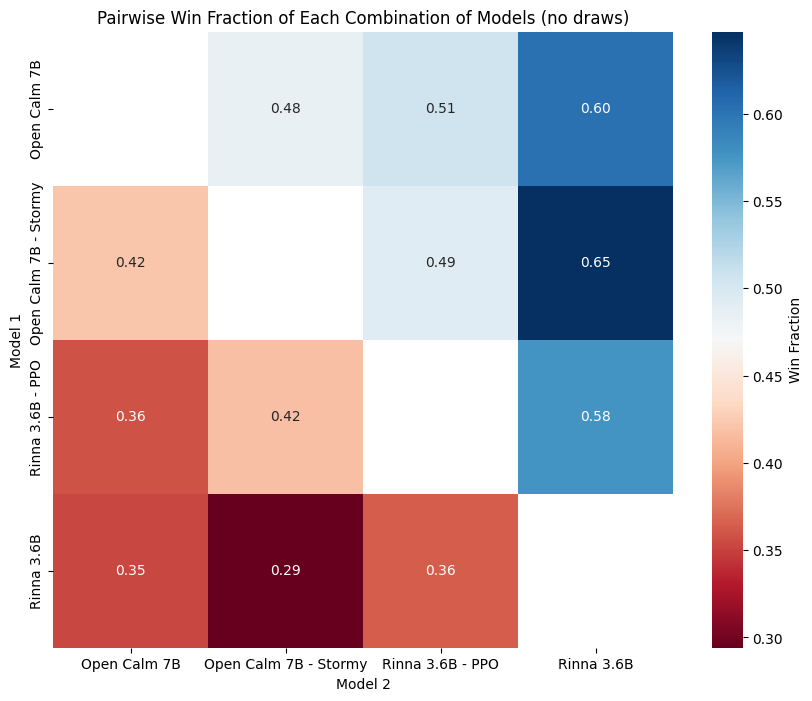

In [12]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns


def compute_pairwise_win_fraction(battles):
    all_models = list(set(battles["bot1"]).union(battles["bot2"]))
    empty_df = pd.DataFrame(0, index=all_models, columns=all_models)

    # Times each model wins as Model A
    a_win_ptbl = pd.pivot_table(
        battles[battles["score"] == 1],
        index="bot1",
        columns="bot2",
        aggfunc="size",
        fill_value=0,
    )

    # Ensure all models appear in the pivot table
    a_win_ptbl = empty_df.add(a_win_ptbl, fill_value=0)

    # Table counting times each model wins as Model B
    b_win_ptbl = pd.pivot_table(
        battles[battles["score"] == 2],
        index="bot1",
        columns="bot2",
        aggfunc="size",
        fill_value=0,
    )

    # Ensure all models appear in the pivot table
    b_win_ptbl = empty_df.add(b_win_ptbl, fill_value=0)

    # Table counting number of A-B pairs
    num_battles_ptbl = pd.pivot_table(
        battles, index="bot1", columns="bot2", aggfunc="size", fill_value=0
    )

    # Computing the proportion of wins for each model as A and as B
    # against all other models
    row_beats_col_freq = (a_win_ptbl + b_win_ptbl.T) / (
        num_battles_ptbl + num_battles_ptbl.T
    )

    # Arrange ordering according to proprition of wins
    prop_wins = row_beats_col_freq.mean(axis=1).sort_values(ascending=False)
    model_names = list(prop_wins.keys())
    row_beats_col = row_beats_col_freq.loc[model_names, model_names]
    return row_beats_col


def visualize_pairwise_win_fraction(battles, title):
    row_beats_col = compute_pairwise_win_fraction(battles)
    fig, ax = plt.subplots(figsize=(10, 8))
    ax = sns.heatmap(
        row_beats_col,
        annot=True,
        fmt=".2f",
        cmap="RdBu",
        cbar_kws={"label": "Win Fraction"},
    )
    ax.set_title(title)
    ax.set_xlabel("Model 2")
    ax.set_ylabel("Model 1")

    # plt.savefig("pairwise_win_fraction.png")
    plt.show()


visualize_pairwise_win_fraction(
    results, title="Pairwise Win Fraction of Each Combination of Models (no draws)"
)

## Confirm elo computation was performed properly

In [13]:
from collections import defaultdict


def compute_elo(battles, K=32, SCALE=400, BASE=10, INIT_RATING=1000, ETA=0):
    rating = defaultdict(lambda: INIT_RATING)

    for rd, model_a, model_b, win in battles[["bot1", "bot2", "score"]].itertuples():
        ra = rating[model_a]
        rb = rating[model_b]
        ea = 1 / (1 + BASE ** ((rb - ra) / SCALE - ETA/np.log(BASE)))
        eb = 1 / (1 + BASE ** ((ra - rb) / SCALE + ETA/np.log(BASE)))
        if win == 1:
            sa = 1
        elif win == 2:
            sa = 0
        elif win == 3:
            sa = 0.5
        else:
            raise Exception(f"unexpected vote {win}")
        rating[model_a] += K * (sa - ea)
        rating[model_b] += K * (1 - sa - eb)

    rating = dict(sorted(rating.items(), key=lambda item: item[1], reverse=True))
    return rating

In [14]:
from elo import INITIAL_ELO, BASE, S, K, ETA 

assert all(
    [
        round(row["elo"], 6) == round(compute_elo(results, K, S, BASE, INITIAL_ELO, ETA)[row["model"]], 6)
        for i, row in standings.iterrows()
    ]
)

In [15]:
standings

,model,elo,num_matches,lower,median,upper,error_y_plus,error_y_minus
0,Open Calm 7B,1037.574,199,1018.647,1044.583,1070.379,25.796,25.937
1,Open Calm 7B - Stormy,1024.059,199,1005.241,1030.341,1055.179,24.838,25.099
2,Rinna 3.6B - PPO,1019.319,200,978.378,1002.161,1025.868,23.707,23.783
3,Rinna 3.6B,919.048,202,898.925,922.740,947.164,24.424,23.815


In [16]:
compute_elo(results, K, S, BASE, INITIAL_ELO, ETA)

{'Open Calm 7B': 1037.5738841514392,
 'Open Calm 7B - Stormy': 1024.059114540312,
 'Rinna 3.6B - PPO': 1019.3191785749123,
 'Rinna 3.6B': 919.0478227333375}

# Predict win rate

In [17]:
def predict_win_rate(standings, K=32, SCALE=400, BASE=10, INIT_RATING=1000):
    names = sorted(list(standings["model"]))
    wins = defaultdict(lambda: defaultdict(lambda: 0))
    for a in names:
        for b in names:
            ea = 1 / (
                1
                + BASE
                ** (
                    (
                        standings.loc[standings["model"] == b, "elo"].values[0]
                        - standings.loc[standings["model"] == a, "elo"].values[0]
                    )
                    / SCALE
                )
            )
            wins[a][b] = ea
            wins[b][a] = 1 - ea

    data = {a: [wins[a][b] if a != b else np.NAN for b in names] for a in names}

    df = pd.DataFrame(data, index=names)
    df.index.name = "model_a"
    df.columns.name = "model_b"
    return df.T

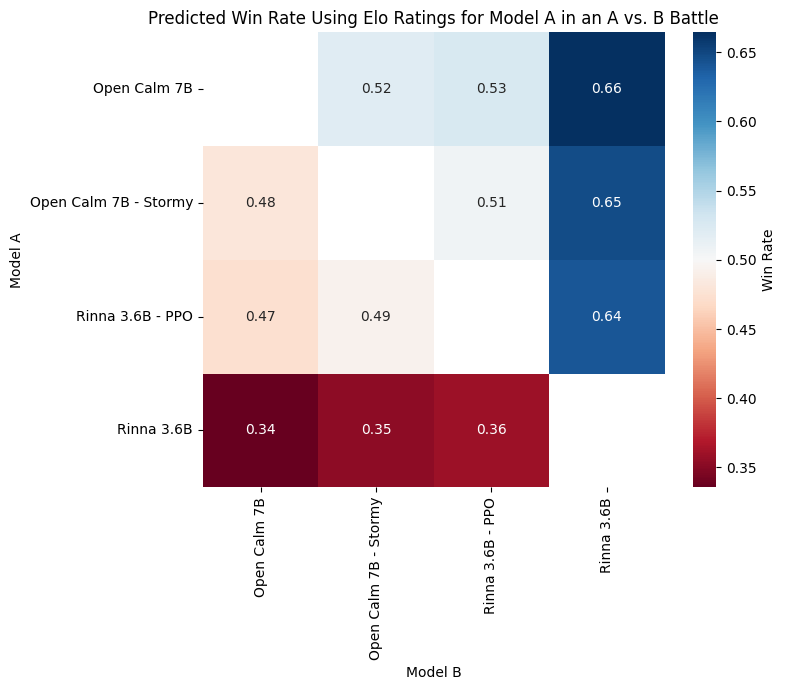

In [18]:
win_rate = predict_win_rate(standings)

ordered_models = win_rate.mean(axis=1).sort_values(ascending=False).index
ordered_win_rate = win_rate.loc[ordered_models, ordered_models]

fig, ax = plt.subplots(figsize=(8, 7))
ax = sns.heatmap(
    ordered_win_rate, annot=True, fmt=".2f", cmap="RdBu", cbar_kws={"label": "Win Rate"}
)
ax.set_title("Predicted Win Rate Using Elo Ratings for Model A in an A vs. B Battle")
ax.set_xlabel("Model B")
ax.set_ylabel("Model A")
plt.tight_layout()
# plt.savefig('elo_predicted_win_rate.png')
plt.show()

### Check bootstrap confidence intervals were properly computed

Here we use bootstrap to estimate the confidence intervals

In [19]:
def get_bootstrap_result(battles, func_compute_elo, num_round):
    rows = []
    for i in tqdm(range(num_round), desc="bootstrap"):
        rows.append(func_compute_elo(battles.sample(frac=1.0, replace=True)))
    df = pd.DataFrame(rows)
    return df[df.median().sort_values(ascending=False).index]


BOOTSTRAP_ROUNDS = 10000

bootstrap_elo_lu = get_bootstrap_result(results, lambda sample: compute_elo(sample, K, S, BASE, INITIAL_ELO, ETA), BOOTSTRAP_ROUNDS)
bootstrap_elo_lu

bootstrap: 100%|██████████| 10000/10000 [00:23<00:00, 428.78it/s]


,Open Calm 7B,Open Calm 7B - Stormy,Rinna 3.6B - PPO,Rinna 3.6B
0,1045.671,1017.505,1030.180,906.644
1,1048.192,1017.368,1021.250,913.190
2,1016.662,1025.876,1041.591,915.872
3,1013.525,1026.238,1044.548,915.689
4,1041.094,1024.342,1003.566,930.998
...,...,...,...,...
9995,1034.544,1041.298,984.612,939.546
9996,1054.687,1033.390,975.235,936.688
9997,1046.649,1038.245,1001.175,913.932
9998,1016.037,1060.827,989.964,933.172


In [20]:
bootstrap_elo = (
    pd.DataFrame(
        dict(
            #lower=bootstrap_elo_lu.quantile(0.025),
            lower=bootstrap_elo_lu.quantile(0.16),
            median=bootstrap_elo_lu.quantile(0.5),
            upper=bootstrap_elo_lu.quantile(0.84),
            #upper=bootstrap_elo_lu.quantile(0.975),
        )
    )
    .reset_index()
    .rename(columns={"index": "model"})
    .sort_values("median", ascending=False)
)
bootstrap_elo["error_y_plus"] = bootstrap_elo["upper"] - bootstrap_elo["median"]
bootstrap_elo["error_y_minus"] = bootstrap_elo["median"] - bootstrap_elo["lower"]

In [21]:
bootstrap_elo

,model,lower,median,upper,error_y_plus,error_y_minus
0,Open Calm 7B,1018.814,1044.589,1070.289,25.700,25.774
1,Open Calm 7B - Stormy,1005.890,1030.555,1055.416,24.861,24.665
2,Rinna 3.6B - PPO,978.513,1002.131,1026.141,24.010,23.618
3,Rinna 3.6B,898.678,922.287,945.760,23.474,23.609


In [22]:
standings

,model,elo,num_matches,lower,median,upper,error_y_plus,error_y_minus
0,Open Calm 7B,1037.574,199,1018.647,1044.583,1070.379,25.796,25.937
1,Open Calm 7B - Stormy,1024.059,199,1005.241,1030.341,1055.179,24.838,25.099
2,Rinna 3.6B - PPO,1019.319,200,978.378,1002.161,1025.868,23.707,23.783
3,Rinna 3.6B,919.048,202,898.925,922.740,947.164,24.424,23.815


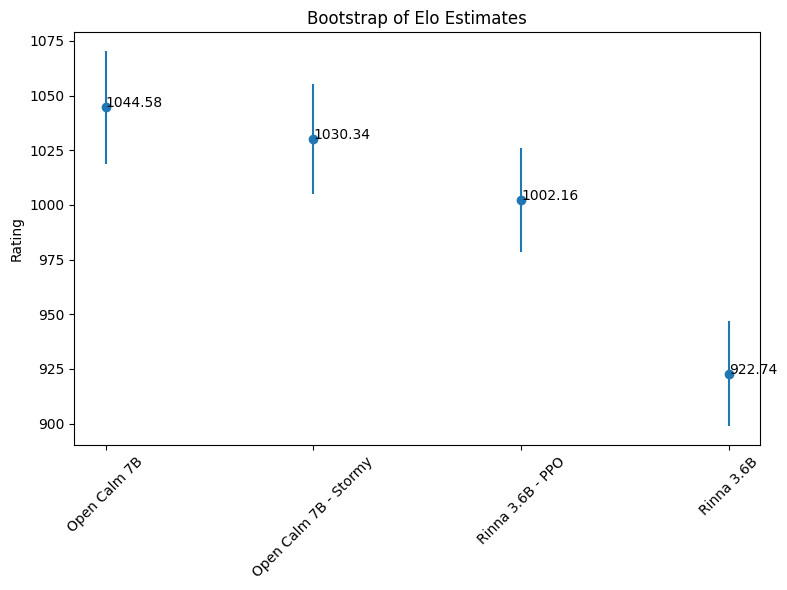

In [25]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.errorbar(
    standings["model"],
    standings["median"],
    yerr=[standings["error_y_minus"], standings["error_y_plus"]],
    fmt="o",
)
for i, txt in enumerate(standings["median"]):
    ax.annotate(round(txt,2), (standings["model"][i], standings["median"][i]))
ax.set_title("Bootstrap of Elo Estimates")
ax.set_ylabel("Rating")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# plt.savefig('bootstrap_elo_estimates.png')
# plotly version
#
# fig = px.scatter(bootstrap_elo, x="model", y="median", error_y="error_y",
#                   error_y_minus="error_y_minus", text="median_rounded",
#                   title="Bootstrap of Elo Estimates")
# fig.update_layout(xaxis_title="Model", yaxis_title="Rating")
# fig.write_html("bootstrap_elo_estimates.html", full_html=False, include_plotlyjs="cdn")
# fig

### Add bootstrap error estimate to time evolution plot

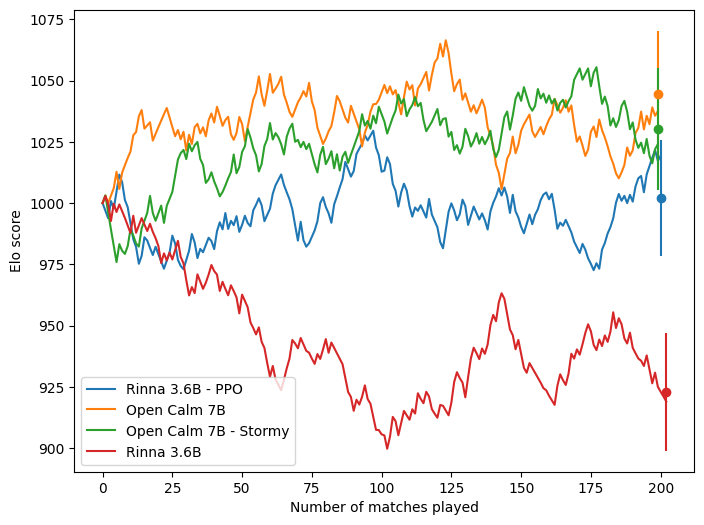

In [26]:
import matplotlib.pyplot as plt

elos = {}
for bot in results.bot1.unique():
    bot_elos = [1000]
    for i, result in results.iterrows():
        if result["bot1"] == bot:
            bot_elos.append(result["postmatch_elo1"])
        elif result["bot2"] == bot:
            bot_elos.append(result["postmatch_elo2"])
        else:
            pass
        
    elos.update({bot: bot_elos})

fig, ax = plt.subplots(figsize=(8, 6))

standings = standings.set_index("model")
for k, v in elos.items():
    line = ax.plot(v, label=k)
    if k in standings.index:  # check if the model has bootstrap estimates
        # plt.errorbar(len(v) - 1, v[-1],
        #              yerr=[[bootstrap_elo.loc[k, 'error_y_minus']],
        #                    [bootstrap_elo.loc[k, 'error_y']]],
        #              fmt='o',color=line[0].get_color())
        ax.errorbar(
            len(v) - 1,
            standings.loc[k, "median"],
            yerr=[
                [standings.loc[k, "error_y_minus"]],
                [standings.loc[k, "error_y_plus"]],
            ],
            fmt="o",
            color=line[0].get_color(),
        )
standings = standings.reset_index()
ax.set_xlabel("Number of matches played")
ax.set_ylabel("Elo score")
plt.legend()